# Fitting a Gaussian process
[Source](https://blog.dominodatalab.com/fitting-gaussian-process-models-python/)

We can describe a Gaussian process as a disribution over functions. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function : $p(x) \sim \mathcal{GP}(m(x), k(x, x'))$

Here we will see the intuition behind it.

### Sampling from a Gaussian Process

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pylab as plt

np.random.seed(42)

$k(x,x')=\theta_1\exp\left(-\frac{\theta_2}{2}(x-x')^2\right)$

In [2]:
def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

We will start with a Gaussian process prior with hyperparameters $\theta_0=0, \theta_1 = 10$. We will also assume a zero function as the mean, so we can plot a band that represents one standard deviation from the mean.

(-3, 3)

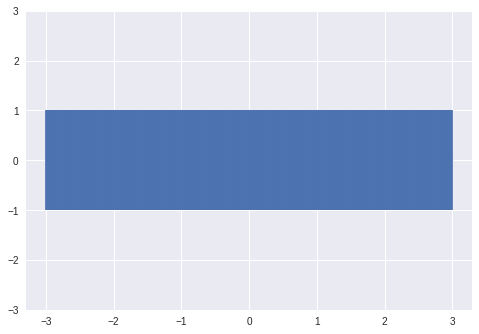

In [3]:
thetas = [1,10]
sigmaf_0 = exponential_cov(0,0, thetas)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigmaf_0, 
             capsize=0)
plt.ylim(-3,3)

Select an arbitrary point, x = 1. Since there are no previous points, we can sample from an unconditional Gaussian

In [4]:
x = [1.]
y = [np.random.normal(scale=sigmaf_0)]
y

[0.4967141530112327]

Update our confidence band, given the point that we just sampled, using the covariance function to generate new pointwise intervals, conditional on the value $[x_0, y_0]$

In [5]:
sigmaf_1 = exponential_cov(x,x, thetas)

In [6]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

In [7]:
x_pred = np.linspace(-3, 3, 1000)
predictions =[predict(i, x, exponential_cov, thetas, 
                      sigmaf_1, y) for i in x_pred]

(-3, 3)

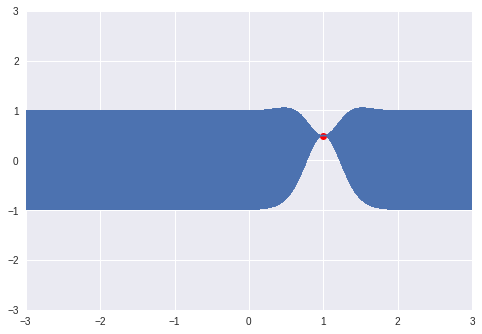

In [8]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

In [9]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

In [10]:
x

[1.0]

In [11]:
y

[0.4967141530112327]

In [12]:
thetas

[1, 10]

In [13]:
m, s = conditional([-0.7], x, y, thetas)

In [14]:
y2 = np.random.normal(m, s)
y2

-0.1382640378102619

In [15]:
x.append(-0.7)
y.append(y2)

In [16]:
sigmaf_2 = exponential_cov(x, x, thetas)
predictions = [predict(i, x, exponential_cov, thetas, 
                       sigmaf_2, y) for i in x_pred]

(-3, 3)

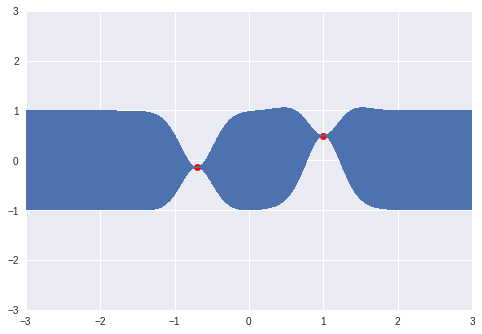

In [17]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.xlim(-3, 3)
plt.ylim(-3, 3)

In [18]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, thetas)
y_more = np.random.multivariate_normal(mu, s)

(-3, 3)

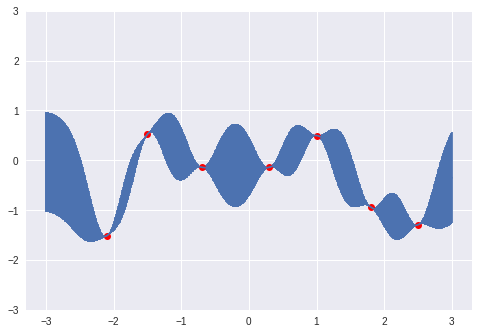

In [19]:
x += x_more
y += y_more.tolist()

sigmaf_new = exponential_cov(x, x, thetas)
predictions = [predict(i, x, exponential_cov, thetas, 
                       sigmaf_new, y) for i in x_pred]

y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, "ro")
plt.ylim(-3, 3)